<div style="text-align: center;">


## **Master 1 ISI - Sorbonne Université**

### **Année universitaire : 2024-2025**

### **Module : Optimisation**
<img src="Sorbonne.jpg" alt="" width="300">


---

### **Titre du projet :**  
#### **Dimensionnement de stockage embarqué dans un tramway**
---
### **Membres de l'équipe :**  
##### **1-CHEMLI Fayçal**  
   
##### **2-BENALI Lounes**  
   
##### **3-AMRANI Amira Yasmine**  

---

</div>

### **Présentation du sujet :**  
Le projet vise à optimiser un système de stockage embarqué pour un tramway dans le cadre d'une alimentation électrique hybride LAC/Batterie.  
Les principaux objectifs incluent :  
- Réaliser une démarche d'optimisation bi-objectifs pour minimiser simultanément le coût de la batterie et la chute de tension maximale.  
- Appliquer des algorithmes d'optimisation, notamment la méthode de Monte Carlo et l'algorithme génétique NSGA-II, pour explorer efficacement l'espace de solutions.  
- Simuler et analyser le comportement du système pour proposer les meilleures configurations en termes de performances et de coût.

---







## **Introduction**

Les tramways modernes, en tant que systèmes de transport en commun efficaces et respectueux de l'environnement, s'appuient sur des réseaux électriques complexes pour fonctionner. Cependant, la gestion de l'énergie dans ces systèmes reste un défi majeur. En particulier, les variations de tension, les pics de demande énergétique, et la récupération d'énergie lors des freinages imposent une réflexion approfondie sur le dimensionnement des systèmes d'alimentation.

L'intégration d'un système de stockage embarqué, comme une batterie, permet d'améliorer la performance globale en stockant l'énergie récupérée et en la restituant aux moments opportuns. Toutefois, cette solution soulève des questions cruciales :  
- Quelle capacité doit avoir la batterie pour répondre aux besoins énergétiques tout en limitant les coûts ?  
- Comment minimiser la chute de tension pour garantir un fonctionnement optimal du tramway ?  

Ce projet se concentre sur ces problématiques en vue de trouver la meilleure solution, capable de concilier efficacité énergétique et contraintes techniques.

<div style="text-align: center;">
    <img src="tram.jpg" alt="Image du tramway" width="500">
</div>



In [1]:
# bibliothèques : 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# fichiers : 
# from fonctions import *
# from NSGA import * 
# from monte_carlo_iteration import *
# from NSGA2 import *

# 1- Simulation et Calcul des Grandeurs Électriques
Dans cette section, nous procédons au calcul des grandeurs électriques nécessaires pour simuler le fonctionnement du système d’alimentation hybride d’un tramway. Les données de déplacement du train et les propriétés physiques des conducteurs sont utilisées pour calculer :

1. La **puissance mécanique** requise à chaque instant.
2. La **tension aux bornes du train** $V_{train}$, en tenant compte de la résistance équivalente.
3. Les **courants électriques** $I_1$, $I_2$ et les **puissances dissipées** $P_1$, $P_2$ dans les différents éléments du circuit.

---

## Équations utilisées

1. **Résistance équivalente ($R_{eq}$)** :  
   La résistance équivalente entre le train et les deux sous-stations est donnée par la relation :  
   $$
   R_{eq} = \frac{R_1 \cdot R_2}{R_1 + R_2}
   $$  
   où $R_1$ et $R_2$ sont les résistances des portions de ligne aérienne de contact (LAC) et des rails.

2. **Tension aux bornes du train ($V_{train}$)** :  
   La tension est calculée en résolvant l’équation quadratique suivante :  
   $$
   V_{train} = 0.5 \cdot \left(V_{sst} + \sqrt{V_{sst}^2 - 4 \cdot R_{eq} \cdot P}\right)
   $$  
   si le discriminant $\Delta = V_{sst}^2 - 4 \cdot R_{eq} \cdot P$ est positif.

3. **Courants et puissances** :  
   Les courants $I$, $I_1$, $I_2$ et les puissances dissipées dans les sous-stations ($P_1$, $P_2$) sont calculés comme suit :  
   $$
   I = \frac{V_{sst} - V_{train}}{R_{eq}}
   $$
   $$
   I_1 = \frac{V_{sst} - V_{train}}{R_{sst} + R_{LAC_1} + R_{rail_1}}
   $$
   $$
   I_2 = \frac{V_{sst} - V_{train}}{R_{sst} + R_{LAC_2} + R_{rail_2}}
   $$
   Les puissances dissipées sont calculées par :  
   $$
   P_1 = R_{sst} \cdot I_1^2
   $$
   $$
   P_2 = R_{sst} \cdot I_2^2
    $$

In [4]:
# import numpy as np 
# import matplotlib.pyplot as plt
from fonctions import * 

# Données du problème
Vsst = 790  
Rsst = 33e-3  
RLAC_per_m = 95e-6  
Rrail_per_m = 10e-6  
Dt = 1

# Charger les données de la marche du train
data = np.loadtxt('marche_train.txt')  
temps = data[:, 0]
position_x = data[:, 1] 

Pmechanique = calculer_puissance_mecanique(temps, position_x)

Ptrain = []
for p_mechanique in Pmechanique:
    if p_mechanique >= 0:
        Ptrain.append(p_mechanique / 0.80 + 35000)
    else:
        Ptrain.append(p_mechanique * 0.80 + 35000)
 
# 1. Calcul de Vtrain
Vtrain = []
for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    delta = Vsst**2 - 4 * Req * P
    if delta >= 0:
        V = 0.5 * (Vsst + np.sqrt(delta))
        Vtrain.append(V)
    else:
        Vtrain.append(np.nan)

# 2. Calcul des courants et des puissances (en dehors de la boucle de Vtrain)
i  = []
i1 = []
i2 = []
P1 = []
P2 = []

for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    V = Vtrain[idx]
    i_value = (Vsst - V) / Req
    i.append(i_value)
    # Calcul des courants i1 et i2
    i1_value = (Vsst - V) / (Rsst + calculer_RLAC(x) + calculer_Rrail(x))
    i2_value = (Vsst - V) / (Rsst + calculer_RLAC(5000 - x) + calculer_Rrail(5000 - x))
    P1_value = (Rsst ) * i1_value**2 
    P2_value = (Rsst ) * i2_value**2 
    i1.append(i1_value)
    i2.append(i2_value)
    P1.append(P1_value)
    P2.append(P2_value)


### 1.1 - Affichage de la tension et la puisance :


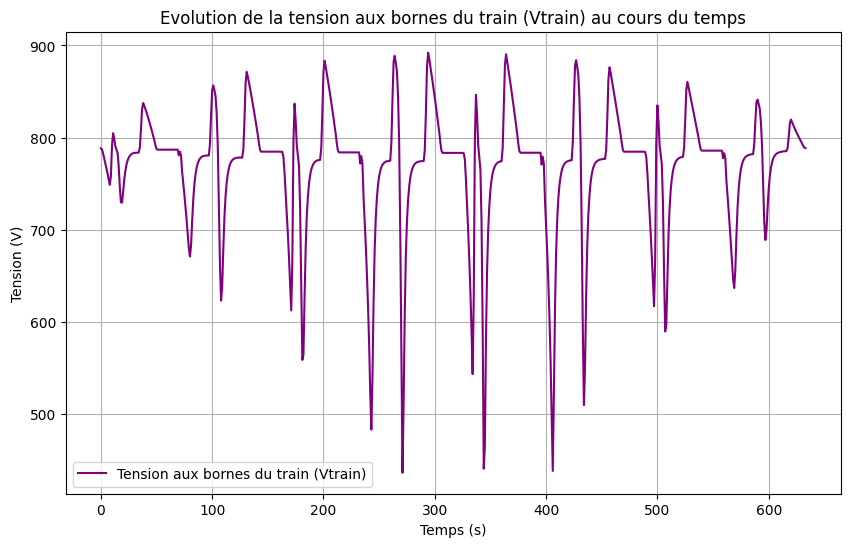

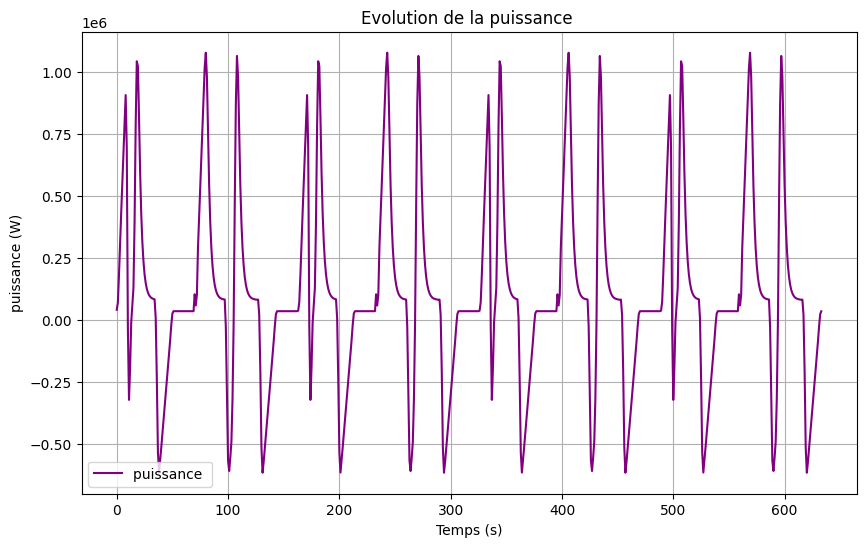

In [22]:
# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(temps, Vtrain, label='Tension aux bornes du train (Vtrain)', color='purple')
plt.title('Evolution de la tension aux bornes du train (Vtrain) au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps, Ptrain, label='puissance ', color='purple')
plt.title('Evolution de la puissance ')
plt.xlabel('Temps (s)')
plt.ylabel('puissance (W)')
plt.legend()
plt.grid(True)
plt.show()



##### Commentaire : 
1- la figure 1  montre l'évolution de la tension aux bornes du train (Vtrain) au fil du temps. On observe des variations importantes de la tension dues aux différentes phases d'accélération, de freinage et de récupération d'énergie. Les pics reflètent les moments où la tension atteint ses valeurs maximales, tandis que les creux correspondent aux phases de forte demande ou d'utilisation intensive de l'énergie stockée.

2- la figure 2  représente la puissance fournie ou consommée par le train au fil du temps. Les parties positives indiquent les phases où le moteur consomme de l'énergie (accélération ou maintien de vitesse), tandis que les parties négatives correspondent aux phases de freinage récupératif. Ces oscillations sont caractéristiques des cycles d'opération d'un tramway.

### 1.2- Affichage les courants et la puissance consommée 

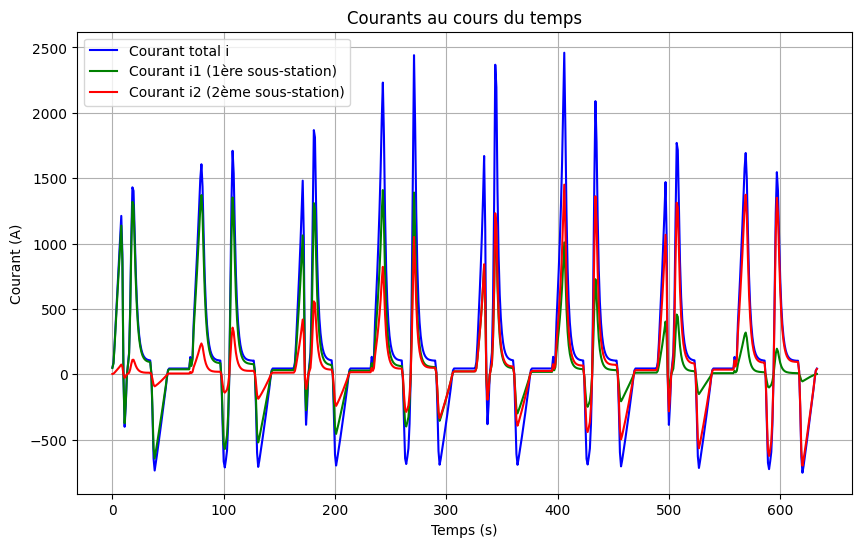

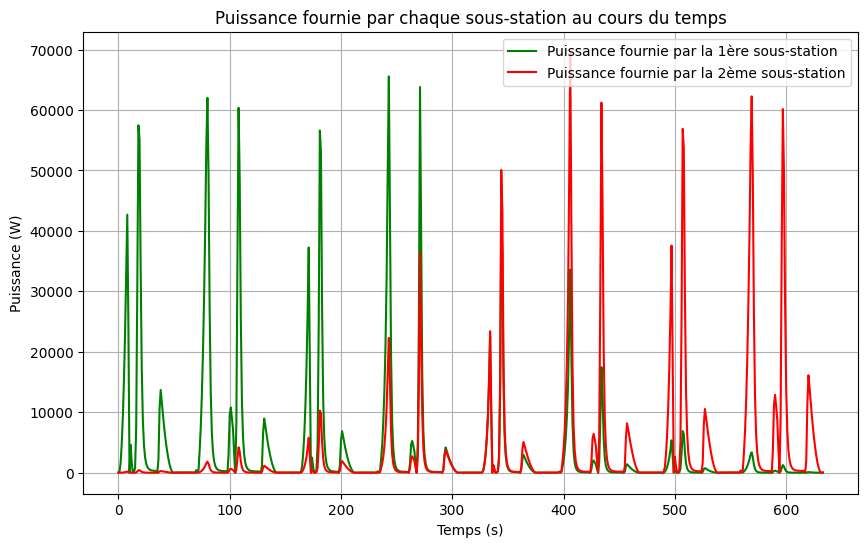

In [23]:
# Tracer les courants (i, i1, i2)
plt.figure(figsize=(10, 6))
plt.plot(temps, i, label='Courant total i', color='blue')
plt.plot(temps, i1, label='Courant i1 (1ère sous-station)', color='green')
plt.plot(temps, i2, label='Courant i2 (2ème sous-station)', color='red')
plt.title('Courants au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Courant (A)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les puissances (P1 et P2)
plt.figure(figsize=(10, 6))
plt.plot(temps, P1, label='Puissance fournie par la 1ère sous-station', color='green')
plt.plot(temps, P2, label='Puissance fournie par la 2ème sous-station', color='red')
plt.title('Puissance fournie par chaque sous-station au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.legend()
plt.grid(True)
plt.show()

##### Commentaire : 
1- la figure 1 illustre l'évolution des courants dans le réseau d'alimentation ferroviaire. Le courant total (en bleu) est réparti entre les deux sous-stations, représentées respectivement par les courbes verte et rouge. Les variations importantes de ces courants traduisent la dynamique de l'alimentation électrique en fonction des besoins énergétiques du train.

2- la figure 2 montre la puissance fournie par les deux sous-stations d'alimentation. Les pics de puissance indiquent les moments de forte demande énergétique, comme les phases d'accélération, tandis que les creux marquent les phases de faible consommation ou de freinage. La répartition entre les deux sous-stations est bien visible, reflétant l'importance de leur coordination pour maintenir une alimentation stable.

Les grandeurs électriques calculées, telles que les variations de tension, les courants et les puissances, permettent de mieux comprendre le comportement du système hybride LAC/batterie. Ces calculs identifient non seulement les instabilités potentielles (par exemple, des chutes de tension critiques), mais aussi les phases où la batterie joue un rôle clé pour soutenir ou limiter les appels de puissance des sous-stations. En optimisant ces paramètres, nous cherchons à garantir une alimentation stable tout en respectant les contraintes énergétiques et économiques du système.

# 2- Gestion de Puissance dans un Système de Batterie Embarqué


La fonction `gestion_puissances` gère la répartition d'énergie entre :
1. **La batterie** : Fournit ou stocke l'énergie.
2. **La LAC (Ligne Aérienne de Contact)** : Source d'alimentation principale.
3. **Le rhéostat** : Dissipe l'énergie excédentaire.

L’objectif est de répondre à la demande énergétique tout en optimisant l’utilisation de la batterie.

---

## **Principe de Fonctionnement**

### 1. **Demande Élevée ($P_{train} \geq P_{seuil}$)**
- La batterie fournit la puissance manquante :  
  $P_{battery} = \min(P_{train} - P_{seuil}, \min(P_{battery\_output\_capacity}, \frac{battery\_level}{Dt}))$
- La LAC complète si nécessaire :  
  $P_{LAC} = P_{seuil} + (P_{train} - P_{seuil} - P_{battery})$


### 2. **Demande Modérée ($0 < P_{train} < P_{seuil}$)**
- La LAC couvre entièrement la demande :  
  $P_{LAC} = P_{train}$
- La batterie et le rhéostat restent inactifs :  
  $P_{battery} = 0$, $P_{rheostat} = 0$



### 3. **Récupération d’Énergie ($P_{train} \leq 0$)**
- L’énergie est stockée dans la batterie si possible :  
  $P_{battery} = \max(P_{train}, -\frac{P_{battery\_input\_capacity}}{Dt})$
- Si la batterie est pleine, l’énergie excédentaire est dissipée :  
  $P_{rheostat} = -P_{train}$


## **Mise à Jour de la Batterie**

- **Décharge** :  
  $battery\_level -= \frac{P_{battery}}{battery\_efficiency} \cdot Dt$
  
- **Charge** :  
  $battery\_level += -P_{battery} \cdot battery\_efficiency \cdot Dt$

---


La fonction retourne :
- $P_{battery}$ : Puissance fournie ou stockée par la batterie.
- $P_{LAC}$ : Puissance fournie par la LAC.
- $P_{rheostat}$ : Puissance dissipée.
- $battery\_level$ : Niveau d’énergie restant dans la batterie.

---



In [24]:

# Parametres du probleme
battery_capacity = 5e6  # en J
P_seuil = 0.5e6 # en W

# Details
battery_level = battery_capacity*0.5     # J
battery_output_capacity = battery_capacity / 10.0  # W
battery_input_capacity = battery_capacity / 10.0   # W
Dt = 1 # en s

# Liste pour stocker les résultats de la batterie
P_battery_list = []
P_LAC_list = []
P_rheostat_list = []
battery_levels = []


# Boucle de simulation pour chaque point de données
for t in range(len(Ptrain)):
    p = Ptrain[t]
    P_battery, P_LAC, P_rheostat, battery_level = gestion_puissances(P_seuil, p, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt)
    
    P_battery_list.append(P_battery)
    P_LAC_list.append(P_LAC)
    P_rheostat_list.append(P_rheostat)
    battery_levels.append(battery_level)



##### Comentaire : 
Dans ce cas, une batterie d'une capacité de 50 MJ a été ajoutée, et la puissance seuil choisie est fixée à 0,5 MW.


### 2.1 - Affichage de différentes puissances :

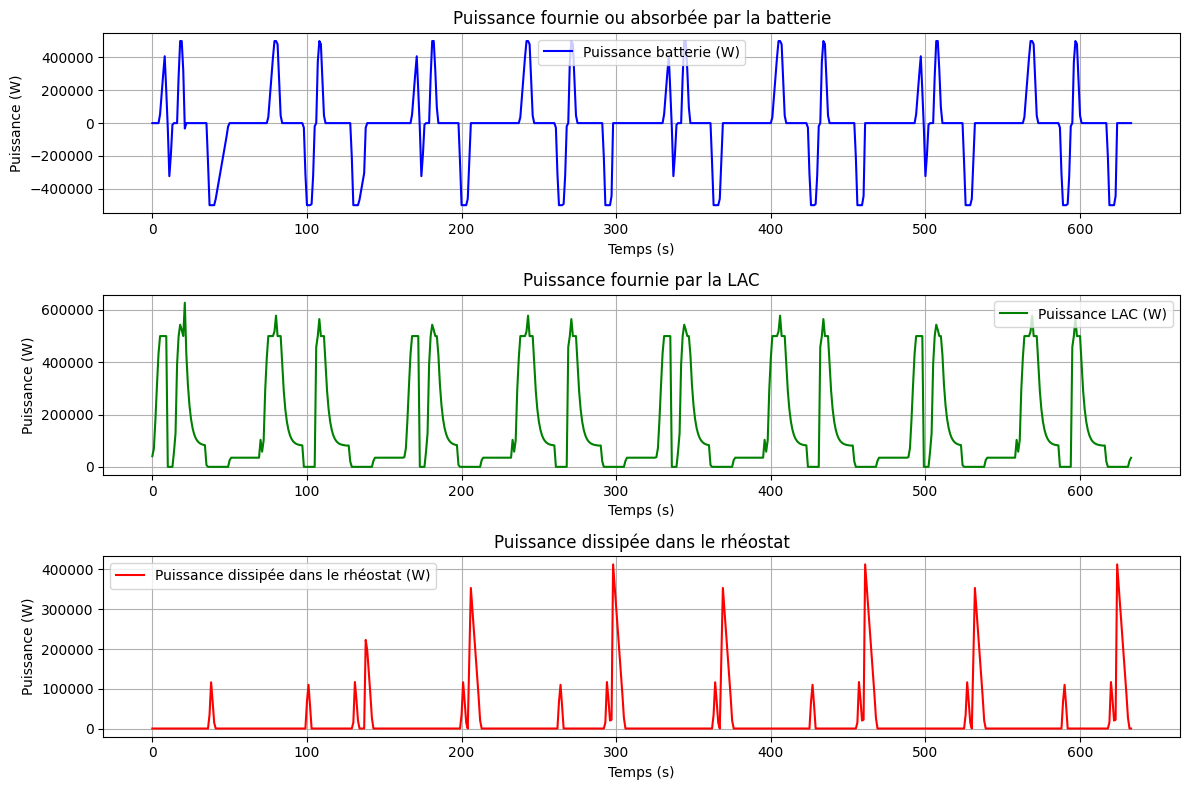

In [25]:
# AFFICHAGE
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(temps, P_battery_list, label='Puissance batterie (W)', color='blue')
plt.title('Puissance fournie ou absorbée par la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(temps, P_LAC_list, label='Puissance LAC (W)', color='green')
plt.title('Puissance fournie par la LAC')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(temps, P_rheostat_list, label='Puissance dissipée dans le rhéostat (W)', color='red')
plt.title('Puissance dissipée dans le rhéostat')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





##### Commentaire : 
- La puissance fournie ou absorbée par la batterie varie en fonction des besoins énergétiques du système. Elle est positive lorsque la batterie fournit de l'énergie et négative lorsqu'elle absorbe l'énergie (phase de recharge).
 
- La puissance fournie par la ligne aérienne de contact (LAC) est toujours positive. Elle fluctue en fonction des demandes énergétiques du train, notamment pendant les phases d'accélération et de freinage.

- La puissance dissipée dans le rhéostat est toujours positive. Elle correspond à l'énergie excédentaire rejetée lors des phases où la récupération par la batterie ou la LAC est insuffisante.

###  2.2- Affichage niveau de la batterie : 

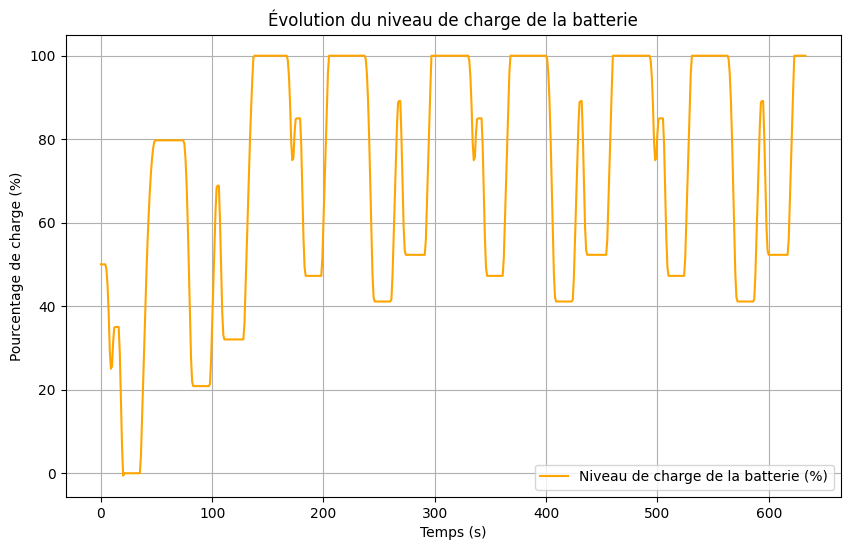

In [26]:
battery_levels_np = np.array(battery_levels)
battery_prctg = 100 * battery_levels_np / battery_capacity

plt.figure(figsize=(10, 6))
plt.plot(temps, battery_prctg, label='Niveau de charge de la batterie (%)', color='orange')
plt.title('Évolution du niveau de charge de la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Pourcentage de charge (%)')
plt.legend()
plt.grid(True)
plt.show()

##### Commentaire : 
La batterie est initialement fixée à 50 % de sa capacité. Son niveau de charge varie :  
- Il augmente pendant les phases de freinage grâce à la récupération d'énergie.  
- Il diminue lors des phases d'accélération ou de forte demande énergétique.

Les résultats montrent comment la batterie intervient pour lisser les variations de puissance, particulièrement dans les phases critiques comme l'accélération ou le freinage. Ces données permettent d'évaluer les performances du système hybride en termes de réduction des pics de puissance et de stabilisation globale du réseau électrique. Les simulations servent également à dimensionner la capacité optimale de la batterie, tout en minimisant les coûts opérationnels.

# 3- Méthode Monte Carlo



La méthode Monte Carlo est utilisée pour explorer de manière aléatoire les paramètres du système afin d'évaluer ses performances dans divers scénarios. Dans ce projet, elle permet de simuler différents compromis entre :  
- La **capacité de la batterie** ($battery\_capacity$).  
- Le **seuil de puissance** ($P_{seuil}$).  
- La **chute de tension maximale** ($chute\_de\_tension\_max$).  

---

## **Principe de Fonctionnement**

### 1. **Tirage Aléatoire des Paramètres**
À chaque itération, les valeurs des paramètres clés sont tirées aléatoirement dans leurs plages respectives :
- Capacité de batterie :  
  $$
  battery\_capacity \sim \mathcal{U}(capacity\_range[0], capacity\_range[1])
  $$
- Seuil de puissance :  
  $$
  P_{seuil} \sim \mathcal{U}(P\_seuil\_range[0], P\_seuil\_range[1])
  $$

### 2. **Simulation Temporelle**
Pour chaque point de temps, les calculs suivants sont effectués :
- **Gestion des puissances** : Répartition de l'énergie entre la batterie, la LAC et le rhéostat.  
- **Calcul de la tension** : Résolution d’une équation quadratique pour déterminer $V_{train}$.  
- **Chute de tension** : Calculée comme :  
  $$
  chute\_tension = V_{sst} - V_{train}
  $$

### 3. **Résultats de l’Itération**
Pour chaque itération, la **chute de tension maximale** est enregistrée, accompagnée des paramètres tirés ($battery\_capacity$, $P_{seuil}$).

---

La méthode Monte Carlo retourne un ensemble de solutions explorées, permettant de visualiser les compromis entre :  
- Réduction de la capacité de la batterie.  
- Minimisation de la chute de tension.



###  3.1- Implémentation d'algorithme  : 

In [27]:
# from tqdm import tqdm
from monte_carlo_iteration import *


capacity_range = (0, 50000000)  # in Joules
P_seuil_range = (0, 1000000)     # in Watts
n_iterations = 1000
Dt = 1

# Run Monte Carlo simulation
results = run_monte_carlo(
    n_iterations,
    capacity_range,
    P_seuil_range,
    gestion_puissances,
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt
)

Monte Carlo Iterations: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 227.28it/s]


##### Commentaire :  
Dans cette partie, nous avons utilisé l'algorithme de Monte Carlo pour trouver la meilleure solution optimale. Nous avons implémenté 1000 itérations avec une puissance seuil ayant des valeurs comprises entre 0 et 1 MW, et une capacité de batterie située entre 0 et 50 MJ.


###  3.2- Affichage espaces des solution et espace des objectifs  : 

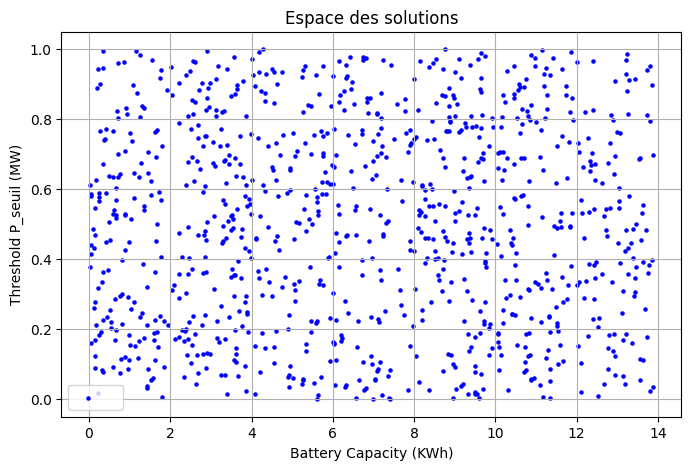

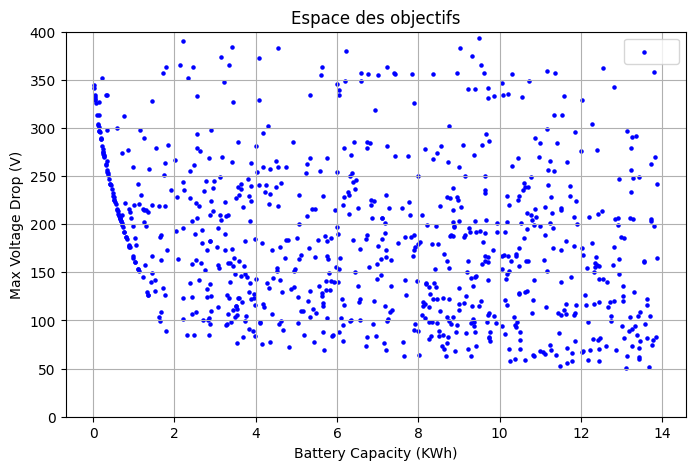

In [14]:
def plot_results(results):
    capacities = [item[0] for item in results]
    p_seuils = [item[1] for item in results]
    voltage_drops = [item[2] for item in results]
    
    capacities_kWh = np.array(capacities) / (3600 * 1000.0)
    p_seuils_MW = np.array(p_seuils) / 1e6
    # -----------------------------------
    # Figure 1: Plot of P_seuil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, p_seuils_MW, c='blue', s=5, label=' ')
    plt.title("Espace des solutions")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Threshold P_seuil (MW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, voltage_drops, c='blue', s=5, label=' ')
    plt.title("Espace des objectifs")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.ylim(0, 400)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_results(results)


#### Commentaire :  
Dans cette partie, nous avons affiché l'espace des solutions (capacité de la batterie et puissance seuil) ainsi que l'espace des objectifs (chute de tension maximale et capacité de la batterie) obtenus à l'aide de la méthode de Monte Carlo. Ces représentations permettent de visualiser les différentes configurations explorées lors des simulations.



###  3.3- Affichage les solutions dominées et non dominées   : 

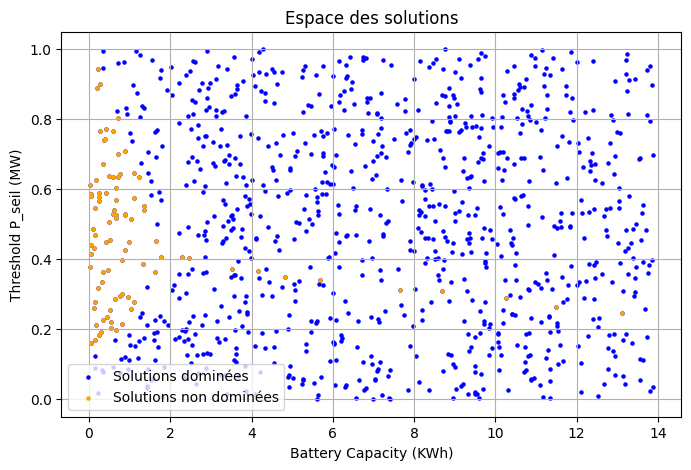

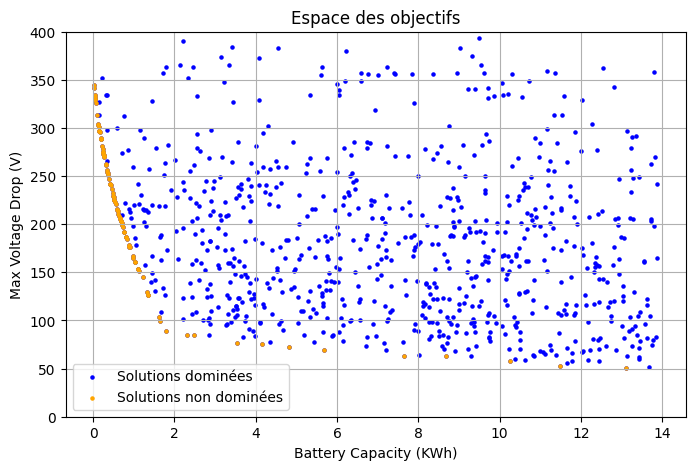

In [15]:
def plot_results(results):
    non_dominated = find_non_dominated_solutions(results)
    
    capacities = [item[0] for item in results]
    p_seuils = [item[1] for item in results]
    voltage_drops = [item[2] for item in results]
    
    non_dom_capacities = [item[0] for item in non_dominated]
    non_dom_p_seuils = [item[1] for item in non_dominated]
    non_dom_voltage_drops = [item[2] for item in non_dominated]
    
    capacities_kWh = np.array(capacities) / (3600 * 1000.0)
    p_seuils_MW = np.array(p_seuils) / 1e6
    non_dom_capacities_kWh = np.array(non_dom_capacities) / (3600 * 1000.0)
    non_dom_p_seuils_MW = np.array(non_dom_p_seuils) / 1e6

    # -----------------------------------
    # Figure 1: Plot of P_seuil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    # Plot all solutions in blue
    plt.scatter(capacities_kWh, p_seuils_MW, c='blue', s=5, label='Solutions dominées')
    # Plot non-dominated solutions in orange
    plt.scatter(non_dom_capacities_kWh, non_dom_p_seuils_MW, c='orange', s=5, label='Solutions non dominées')
    plt.title("Espace des solutions")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Threshold P_seil (MW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, voltage_drops, c='blue', s=5, label='Solutions dominées')
    plt.scatter(non_dom_capacities_kWh, non_dom_voltage_drops, c='orange', s=5, label='Solutions non dominées')
    plt.title("Espace des objectifs")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.ylim(0, 400)
    plt.grid(True)
    plt.legend()
    plt.show()
0
plot_results(results)

##### Commentaire :  
Dans cette partie, nous avons affiché les solutions dominées et non dominées. On observe clairement l'apparition de la courbe de Pareto, représentant les compromis optimaux entre les objectifs.


###  3.4- Affichage les solutions non dominées et meilleures solutions   : 

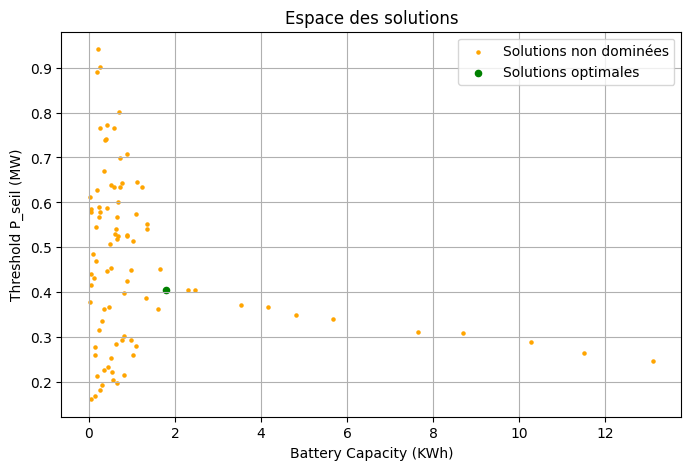

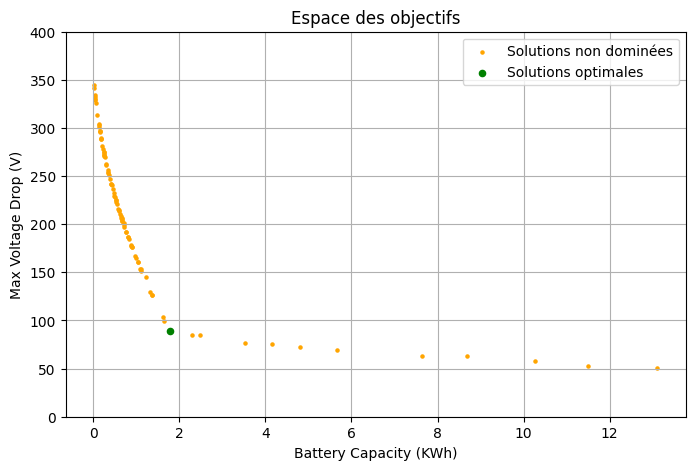

Les meilleures solutions sélectionnées sont : Capacité = 1.78 kWh, Puissance seuil = 0.41 MW, Chute de tension = 89.29 V


In [17]:
def plot_results(results):
    non_dominated = find_non_dominated_solutions(results)
    
    non_dom_capacities = [item[0] for item in non_dominated]
    non_dom_p_seuils = [item[1] for item in non_dominated]
    non_dom_voltage_drops = [item[2] for item in non_dominated]
    
    # Filter non-dominated solutions with voltage drop < 90 V and capacity < 2 kWh
    filtered_capacities = [item[0] for item in non_dominated if item[2] < 90 and item[0] / (3600 * 1000.0) < 2.2]
    filtered_p_seuils = [item[1] for item in non_dominated if item[2] < 90 and item[0] / (3600 * 1000.0) < 2.2]
    filtered_voltage_drops = [item[2] for item in non_dominated if item[2] < 90 and item[0] / (3600 * 1000.0) < 2.2]
    
    non_dom_capacities_kWh = np.array(non_dom_capacities) / (3600 * 1000.0)
    non_dom_p_seuils_MW = np.array(non_dom_p_seuils) / 1e6
    non_dom_voltage_drops = np.array(non_dom_voltage_drops)
    
    filtered_capacities_kWh = np.array(filtered_capacities) / (3600 * 1000.0)
    filtered_p_seuils_MW = np.array(filtered_p_seuils) / 1e6
    filtered_voltage_drops = np.array(filtered_voltage_drops)


    # -----------------------------------
    # Figure 1: Plot of P_seuil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    # Plot non-dominated solutions in orange
    plt.scatter(non_dom_capacities_kWh, non_dom_p_seuils_MW, c='orange', s=5, label='Solutions non dominées')
    # Highlight filtered non-dominated solutions in green
    plt.scatter(filtered_capacities_kWh, filtered_p_seuils_MW, c='green', s=20, label='Solutions optimales ')
    plt.title("Espace des solutions")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Threshold P_seil (MW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(non_dom_capacities_kWh, non_dom_voltage_drops, c='orange', s=5, label='Solutions non dominées')
    # Highlight filtered non-dominated solutions in green
    plt.scatter(filtered_capacities_kWh, filtered_voltage_drops, c='green', s=20, label='Solutions optimales ')
    plt.title("Espace des objectifs")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.ylim(0, 400)
    plt.grid(True)
    plt.legend()
    plt.show()
        # Print the filtered solutions
    for i in range(len(filtered_voltage_drops)):
        print(f"Les meilleures solutions sélectionnées sont : Capacité = {filtered_capacities_kWh[i]:.2f} kWh, "
              f"Puissance seuil = {filtered_p_seuils_MW[i]:.2f} MW, "
              f"Chute de tension = {filtered_voltage_drops[i]:.2f} V")


plot_results(results)


##### Commentaire :  
Parmi les meilleures solutions identifiées, nous avons :  
- Capacité = 1.78 kWh, Puissance seuil = 0.41 MW, Chute de tension = 89.29 V  

Ces solutions montrent qu'il existe un compromis entre la capacité de la batterie et la chute de tension. Par exemple, une capacité légèrement plus élevée (1.78 kWh) permet une chute de tension modérée (89.29 V). Cela démontre que pour des priorités différentes, il est possible d’ajuster ces paramètres pour trouver un équilibre optimal.

Ces résultats confirment l'efficacité de la méthode Monte Carlo pour identifier des solutions optimales adaptées aux priorités définies, que ce soit en minimisant la capacité ou la chute de tension.


# 4- Optimisation Multi-Objectifs avec NSGA-II




## **Mise en Œuvre avec Pymoo**

### 1. **Le Problème**

La classe `BatteryOptimizationProblem` modélise le problème d’optimisation avec :
- **Deux variables de décision** :
  - Capacité de la batterie ($battery\_capacity$).  
  - Seuil de puissance ($P_{seuil}$).  
- **Deux objectifs** :
  - Minimiser la capacité de la batterie.  
  - Minimiser la chute de tension maximale.

Les limites des variables sont définies par :  
$$
0 \leq battery\_capacity \leq 50000000, \quad 0 \leq P_{seuil} \leq 1000000
$$


### 2. **Évaluation des Solutions**

Pour chaque solution proposée ($x = [battery\_capacity, P_{seuil}]$), les étapes suivantes sont effectuées :
- Simulation temporelle pour calculer :
  - La chute de tension maximale ($chute\_de\_tension\_max$).
  - L’utilisation énergétique de la batterie.
- Résolution de l’équation quadratique pour déterminer la tension aux bornes du train ($V_{train}$).



### 3. **Optimisation avec NSGA-II**

L’algorithme génétique NSGA-II génère une population de solutions et évolue sur plusieurs générations pour identifier un **front de Pareto** optimal.  
Les solutions du front représentent les meilleurs compromis entre :  
- Réduction de la capacité de la batterie.  
- Minimisation de la chute de tension maximale.


L'implémentation avec **Pymoo** permet :
1. Une exploration efficace des solutions optimales.  
2. La visualisation du front de Pareto, mettant en évidence les compromis entre les deux objectifs.


###  4.1- Implémentation de l'algorithme   : 

In [26]:
# from pymoo.core.problem import ElementwiseProblem
# import numpy as np
# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.optimize import minimize
# import matplotlib.pyplot as plt
from NSGA import *



def visualize_results(results):
    # Pareto front visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(results.F[:, 0], results.F[:, 1], c='blue', label='Solutions')
    plt.xlabel('Battery Capacity (J)')
    plt.ylabel('Maximum Voltage Drop (V)')
    plt.title('Pareto Front of Battery Optimization')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Solutions distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.hist(results.X[:, 0], bins=30)
    ax1.set_xlabel('Battery Capacity (J)')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Battery Capacity')

    ax2.hist(results.X[:, 1], bins=30)
    ax2.set_xlabel('P_seuil (W)')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of P_seuil')
    
    plt.tight_layout()
    plt.show()

def run_nsga2_optimization(temps, position_x, Ptrain, Vsst, calculer_Req, Dt, gestion_puissances):
    problem = BatteryOptimizationProblem(
        temps, position_x, Ptrain, Vsst, calculer_Req, Dt, gestion_puissances
    )

    algorithm = NSGA2(
        pop_size=100,
        n_offsprings=100
    )

    termination = ('n_gen', 100)

    res = minimize(
        problem,
        algorithm,
        termination,
        seed=1,
        save_history=True,
        verbose=True
    )

    visualize_results(res)
    
    return res


###  4.2- Affichage des résultats   : 

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     19 |             - |             -
     2 |      200 |     34 |  0.0045024848 |         ideal
     3 |      300 |     58 |  0.0117165895 |             f
     4 |      400 |    100 |  0.0055055310 |             f
     5 |      500 |    100 |  0.0123891779 |         ideal
     6 |      600 |    100 |  0.0148618903 |         ideal
     7 |      700 |    100 |  0.0019145156 |             f
     8 |      800 |    100 |  0.0026155922 |             f
     9 |      900 |    100 |  0.0032923186 |             f
    10 |     1000 |    100 |  0.0016458287 |             f
    11 |     1100 |    100 |  0.0032523421 |             f
    12 |     1200 |    100 |  0.0016024296 |             f
    13 |     1300 |    100 |  0.0029863798 |             f
    14 |     1400 |    100 |  0.0014082713 |             f
    15 |     1500 |    100 |  0.0030895518 |             f
    16 |     1600 |    100 |  0.0017854653 |            

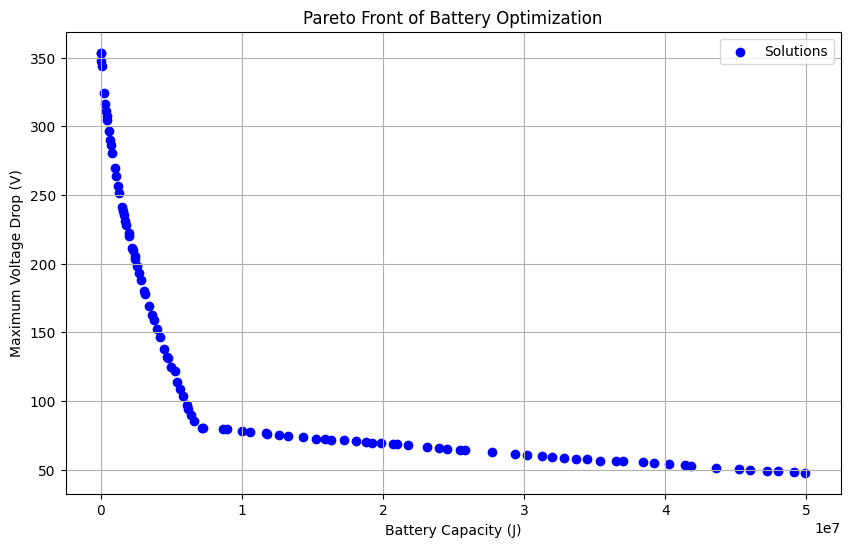

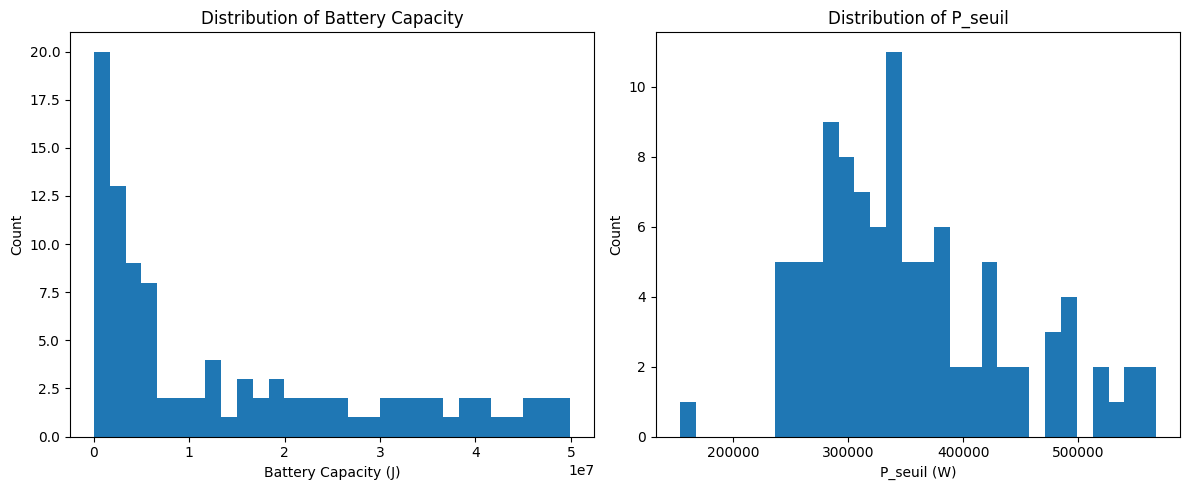

In [25]:
results = run_nsga2_optimization(
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt,
    gestion_puissances
)

### Commentaires :

- La première figure montre clairement le compromis entre la capacité de la batterie et la chute de tension maximale. Les solutions à gauche minimisent la capacité, mais augmentent la chute de tension, tandis que celles à droite réduisent la chute de tension avec une capacité plus élevée.


- L'histogramme révèle que la majorité des solutions optimales se concentrent sur des petites capacités de batterie (< 2 kWh), ce qui est favorable pour réduire le coût.


- Les solutions optimales pour le seuil de puissance (\( P\_seuil \)) sont principalement regroupées autour de valeurs moyennes, indiquant un bon équilibre entre la performance et l'efficacité énergétique.
 
Ces figures démontrent que la méthode NSGA-II permet de trouver des solutions adaptées et optimales en fonction des priorités, en explorant efficacement les compromis entre les objectifs.


# 5 - Optimisation Multi-Objectifs : NSGA-II Implémenté à Partir de Zéro



### 1. **Modélisation avec la Classe `Individu`**

Chaque solution est représentée par un individu contenant :
- **Variables de décision** ($x = [battery\_capacity, P_{seuil}]$).  
- **Objectifs** : $[battery\_capacity, chute\_de\_tension\_max]$.  
- **Rang** : Défini par la domination de Pareto.  
- **Distance de Crowding** : Mesure la diversité des solutions proches sur le front.

---

### 2. **Étapes de NSGA-II**

#### a. **Initialisation**
- Une population initiale est générée aléatoirement dans les limites des variables :  
  $0 \leq battery\_capacity \leq 50000000$,  
  $0 \leq P_{seuil} \leq 1000000$.

#### b. **Évaluation des Individus**
- Chaque individu est évalué en simulant le comportement du système pour calculer les objectifs.

#### c. **Tri Non Dominé**
- Les individus sont classés en fronts selon la méthode de Pareto :
  - Un individu domine un autre s’il est meilleur sur tous les objectifs et strictement meilleur sur au moins un.

#### d. **Création des Descendants**
- **Sélection par tournoi** : Les meilleurs individus sont sélectionnés pour la reproduction.  
- **Croisement** : Les variables des parents sont combinées pour générer de nouveaux individus.  
- **Mutation** : De petites variations aléatoires sont appliquées pour explorer de nouvelles solutions.

#### e. **Sélection de la Nouvelle Génération**
- Les individus des fronts non dominés sont ajoutés à la nouvelle population jusqu’à atteindre la taille requise.
- Les individus restants sont triés par **distance de crowding** pour maintenir la diversité.





###  5.1- Implémentation de l'algorithme   : 

Génération 0
Génération 10
Génération 20
Génération 30
Génération 40
Génération 50
Génération 60
Génération 70
Génération 80
Génération 90


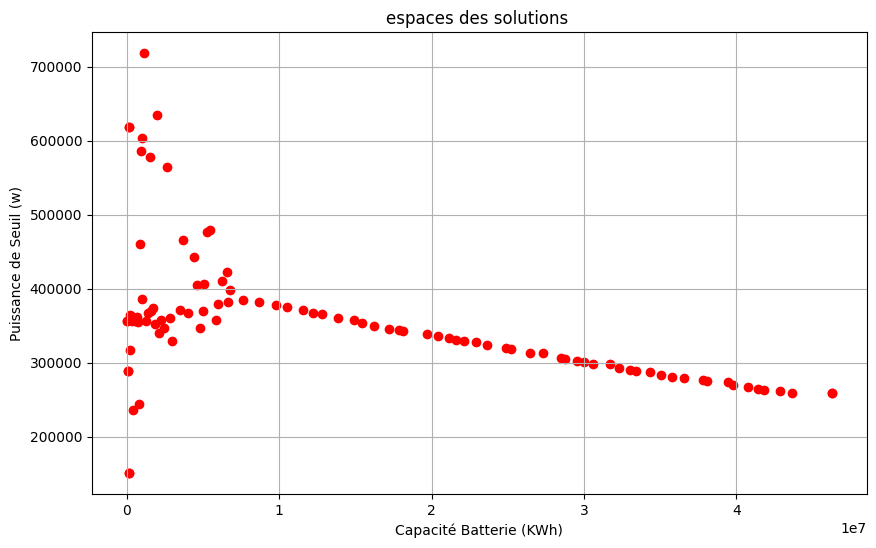

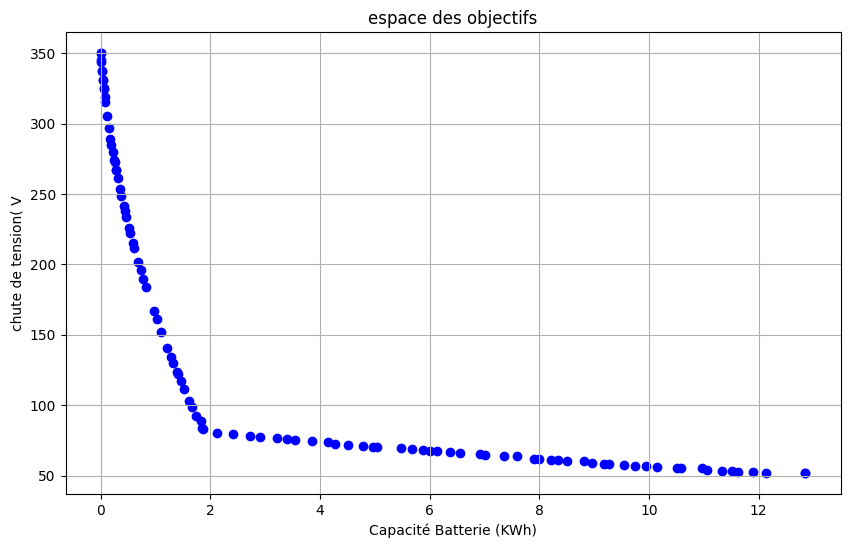

In [5]:
# Utilisation du code précedent pour appliquer NSGA2
# import random
from NSGA2 import *
 


bornes = [(0, 50000000), (0, 1000000)]
parametres_probleme = {
    'temps': temps,
    'position_x': position_x,
    'Ptrain': Ptrain,
    'Vsst': Vsst,
    'calculer_Req': calculer_Req,
    'Dt': Dt,
    'gestion_puissances': gestion_puissances
}

population_finale = nsga2(
    parametres_probleme=parametres_probleme,
    taille_pop=100,
    nb_generations=100,
    bornes=bornes
)

afficher_resultats(population_finale)


##### Commentaires :
graphe 1 :  
- Ce graphique montre les différentes solutions explorées par NSGA-II. On observe qu'une capacité de batterie plus élevée permet de réduire la puissance seuil nécessaire
- La décroissance reflète un compromis optimal : augmenter la capacité de batterie peut diminuer la puissance instantanée requise, mais cela a un coût énergétique.
graphe 2 : 
- Ce graphique représente le front de Pareto. Les points montrent les meilleurs compromis entre une chute de tension faible et une capacité de batterie réduite.
- La courbe décroissante illustre que des capacités de batterie plus grandes réduisent la chute de tension, mais les gains deviennent moins significatifs au-delà d’un certain seuil.

## **Conclusion**

Ce projet avait pour objectif principal d'optimiser le système hybride LAC/batterie d’un tramway en réduisant les chutes de tension et en minimisant la capacité de la batterie. Pour atteindre ces objectifs, deux approches ont été implémentées et analysées :
- La méthode de Monte Carlo pour explorer un large éventail de configurations de manière exhaustive.
- L’algorithme NSGA-II, conçu à partir de zéro, pour une optimisation plus ciblée et efficace, permettant d’identifier des solutions Pareto-optimales.

Réalisation : 

Modélisation et simulation :

- Les grandeurs électriques clés (chute de tension, puissance seuil, capacité de batterie) ont été modélisées et calculées pour évaluer le comportement du système.
- Les relations entre les variables de décision et les objectifs ont été clairement définies et simulées.

Optimisation multi-objectif :

- La méthode de Monte Carlo a permis d’explorer l’espace des solutions et de fournir un premier aperçu des compromis possibles.
- L’algorithme NSGA-II a été implémenté pour identifier efficacement le front de Pareto, démontrant des compromis optimaux entre la capacité de la batterie et la chute de tension.

Résultats visuels :

- Les graphiques obtenus (espace des solutions et espace des objectifs) ont mis en évidence les tendances clés et les compromis, offrant des solutions exploitables pour le dimensionnement du système.

Impact des résultats :
Les résultats obtenus montrent que :

- Une capacité de batterie plus grande réduit les chutes de tension et diminue les exigences sur la puissance seuil, mais au prix d’un coût énergétique plus élevé.
- Les solutions identifiées sur le front de Pareto fournissent une base solide pour prendre des décisions de conception éclairées, en équilibrant les performances et les coûts.